In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,t
from scipy.optimize import minimize
import statsmodels as sm
import random
import scipy.optimize as optimize
from statsmodels.tsa import ar_model
import scipy

Problem1=pd.read_csv("problem1.csv")
Daily_Price = pd.read_csv("DailyPrices.csv")
portfolio= pd.read_csv("portfolio.csv")

In [24]:
# problem1

# Fit a Normal Distribution 
def norm_ES(x,alpha):
    miu = x.mean()
    x_adj=x-miu
    sigma = x_adj.std()
    norm_VaR = -norm.ppf(alpha,loc=miu,scale=sigma)
    
   
    ES_norm =- miu + sigma*norm.pdf(norm.ppf(alpha))/alpha
    print("When alpha = "+str(alpha)+" :")
    print("The VaR fitted a Normal Distribution is "+str(norm_VaR))
    print("The Expected Shortfall is "+str(ES_norm))
   
    return norm_VaR, ES_norm

# t distribution:
def MLE_t(pars, x):
    df = pars[0]
    loc=pars[1]
    scale = pars[2]
    ll = np.log(t.pdf(x, df=df,loc=loc,scale=scale)) 
    return -ll.sum()


def t_ES(x, alpha):
    mean_x=x.mean()
    std_x=x.std()
    cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2}, {'type': 'ineq', 'fun': lambda x:  x[2]})
    model = optimize.minimize(fun = MLE_t,  x0 = [2, mean_x,std_x ], constraints=cons, args =x).x
    
    df=model[0]
    loc=model[1]
    scale=model[2]
    t_sample = t.rvs(df =df, loc = loc, scale = scale, size = 10000)
    
    t_VaR=-t.ppf(alpha, df =df, loc = loc, scale = scale)
    
    ES_t=-t_sample[t_sample<-t_VaR].mean()
    
    print("When alpha = "+str(alpha)+" :")
    print("The VaR fitted a T Distribution is "+str(t_VaR))
    print("The Expected Shortfall is "+str(ES_t))
    
    return  df,loc,scale,t_VaR,ES_t



    

When alpha = 0.05 :
The VaR fitted a Normal Distribution is 0.0813353274763361
The Expected Shortfall is 0.10177426982904988
When alpha = 0.05 :
The VaR fitted a T Distribution is 0.07647580735513254
The Expected Shortfall is 0.1115321584017986


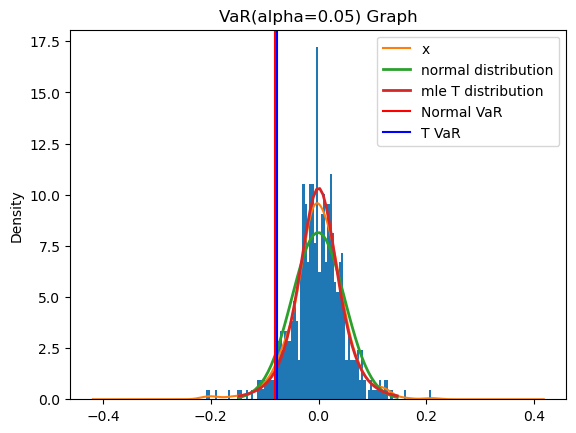

In [25]:
norm_VaR, ES_norm=norm_ES(Problem1['x'],0.05)
df,loc,scale,t_VaR,ES_t=t_ES(Problem1['x'],0.05)

plt.cla()
Problem1['x'].hist(bins=100,density=True) 
Problem1['x'].plot(kind='kde', label = "x")
u=Problem1['x'].mean()
sigma=Problem1['x'].std()

x = np.linspace(u - 3*sigma, u + 3*sigma) 
y_norm = norm.pdf(x, loc = u, scale = sigma)
y_t=t.pdf(x,df=df,loc=loc,scale=scale)
plt.plot(x, y_norm, linewidth=2, label = "normal distribution")
plt.plot(x, y_t, linewidth=2, label = "mle T distribution")
plt.axvline(-norm_VaR,color='r', label='Normal VaR')
plt.axvline(-t_VaR,color='b', label='T VaR')

plt.legend()
plt.title("VaR(alpha=0.05) Graph")
plt.show()

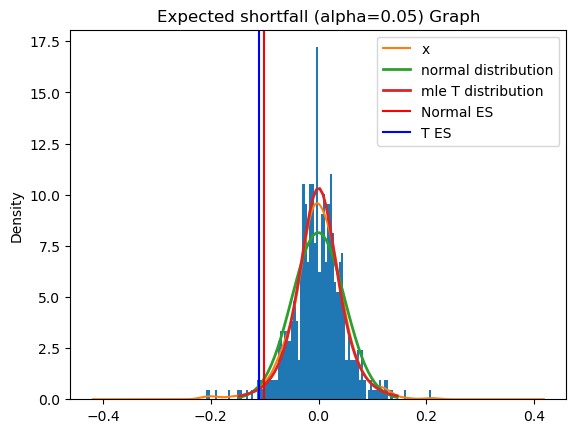

In [4]:
plt.cla()
Problem1['x'].hist(bins=100,density=True) 
Problem1['x'].plot(kind='kde', label = "x")
u=Problem1['x'].mean()
sigma=Problem1['x'].std()

x = np.linspace(u - 3*sigma, u + 3*sigma) 
y_norm = norm.pdf(x, loc = u, scale = sigma)
y_t=t.pdf(x,df=df,loc=loc,scale=scale)
plt.plot(x, y_norm, linewidth=2, label = "normal distribution")
plt.plot(x, y_t, linewidth=2, label = "mle T distribution")
plt.axvline(-ES_norm,color='r', label='Normal ES')
plt.axvline(-ES_t,color='b', label='T ES')

plt.legend()
plt.title("Expected shortfall (alpha=0.05) Graph")
plt.show()

In [5]:
# Problem 2:

from risk_manage import cov, psd, var, simulation,es

def test_ewCov(lamda):

    
    Daily_return = pd.read_csv("DailyReturn.csv")
    Daily_return=Daily_return.rename(columns={"Unnamed: 0": "Date"})
    Daily_return=Daily_return.drop(columns='Date')
    cov_mat_t = cov.Cal_cov_matrix(lamda,Daily_return)
    
    return cov_mat_t

def test_psd(n):
    sigma = np.full((n,n),0.9)
    for i in range(n):
        sigma[i,i]=1

    expected_result = np.linalg.cholesky(sigma)

    t_result = psd.chol_psd(sigma)
    
    print("The expected result is ")
    print(expected_result)
    print("The testing result is ")
    print(t_result)
    

    if abs(expected_result - t_result).sum() < 1e-8:
        print("The imported function is correct")
        
def if_PSD(A):
    vals,vecs=np.linalg.eigh(A)
    n=len(A)
    vals=sorted(vals)
    
    if vals[0]>-1e-8:
        print("The fixed matrix is PSD")
    else:
        print("The fixed matrix is not PSD")
        
def test_convert_psd(n):
    sigma = np.full((n,n),0.9)
    for i in range(n):
        sigma[i,i]=1
    
    sigma[0,1] = 0.7357
    sigma[1,0] = 0.7357 
    
    h_sigma=psd.Higham_2002(sigma)
    n_sigma=psd.near_psd(sigma)
    h_frob=psd.Frobenius_Norm(h_sigma-sigma)
    n_frob=psd.Frobenius_Norm(n_sigma-sigma)
    
    print("Higham testing:")
    if_PSD(h_sigma)
    
    
    print("near_psd testing:")
    if_PSD(n_sigma)
    
    print("The Frobenius_Norm of Higham method for nearest psd = "+ str(h_frob))
    print("The Frobenius_Norm of near_psd method for nearest psd = "+ str(n_frob))
    
def test_simulation(n=1000,sigma=0.05,p0=100,t=100,size=25000,n_val=0.75):
    # direct simulate & PCA simulate
    Daily_return = pd.read_csv("DailyReturn.csv")
    Daily_return=Daily_return.rename(columns={"Unnamed: 0": "Date"})
    Daily_return=Daily_return.drop(columns='Date')
    cov_mat_t = cov.Cal_cov_matrix(0.97,Daily_return)
    ds=simulation.direct_simulate(cov_mat_t,size)
    pca_simulation=simulation.PCA_simulate(cov_mat_t,size,n_val)
    print("Direct simulation:")
    print(ds)
    print("PCA simulation")
    print(pca_simulation)
    
    # Brownian motion methods
    simulation.test_std(n,sigma,p0,t)
    
def test_VaR(alpha):
    df = pd.read_csv('DailyPrices.csv')
    return_df=var.return_calculate('ArithmeticReturn',df,'Date').dropna().reset_index()
    return_meta=return_df['META']
    meta_mean=np.mean(return_meta)
    
    adj_meta_mean=return_df['META']-meta_mean # remove mean of META
    miu = 0

    print("When alpha = "+str(alpha))
    norm_var =var.Norm_VaR(adj_meta_mean,0,alpha)

    print("The VaR of using a normal distribution = "+str(norm_var))
    ew_var =var.EW_VaR(np.array(adj_meta_mean),0,alpha,0.94)
    print("The VaR of using a normal distribution with an Exponentially Weighted variance (λ = 0. 94) = "+str(ew_var))
    mle_var =var.MLE_T_VaR(adj_meta_mean,0,0.05)
    print("The VaR of using a MLE fitted T distribution = "+str(mle_var))
    ar_var =var.AR_VaR(adj_meta_mean,0,alpha)
    print("The VaR of using a fitted AR(1) model = "+str(ar_var))
    his_var =var.Historic_Simulation(adj_meta_mean,alpha,1000)
    print("The VaR of using a Historic Simulation = "+str(his_var))

def test_es(x,alpha):
    norm_VaR, ES_norm=es.norm_ES(x,alpha)
    print("When alpha = "+str(alpha)+" :")
    print("The VaR fitted a Normal Distribution is "+str(norm_VaR))
    print("The Expected Shortfall is "+str(ES_norm))
    df,loc,scale,t_VaR, ES_t=es.t_ES(x,alpha)
    print("When alpha = "+str(alpha)+" :")
    print("The VaR fitted a Normal Distribution is "+str(t_VaR))
    print("The Expected Shortfall is "+str(ES_t))
    
    return  


ModuleNotFoundError: No module named 'risk_manage'

In [12]:
test_ewCov(0.97)

array([[8.41106909e-05, 1.06945662e-04, 1.21760871e-04, ...,
        1.25484463e-04, 8.11331555e-05, 8.61130395e-05],
       [1.06945662e-04, 2.68752303e-04, 1.97531665e-04, ...,
        1.15658764e-04, 3.74977522e-05, 8.22220854e-05],
       [1.21760871e-04, 1.97531665e-04, 2.91157502e-04, ...,
        8.30278956e-05, 3.31844912e-05, 7.34713753e-05],
       ...,
       [1.25484463e-04, 1.15658764e-04, 8.30278956e-05, ...,
        7.47889224e-04, 2.68371109e-04, 2.00639601e-04],
       [8.11331555e-05, 3.74977522e-05, 3.31844912e-05, ...,
        2.68371109e-04, 3.08241679e-04, 8.21009546e-05],
       [8.61130395e-05, 8.22220854e-05, 7.34713753e-05, ...,
        2.00639601e-04, 8.21009546e-05, 2.62692778e-04]])

In [13]:
test_psd(10)

The expected result is 
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9        0.43588989 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9        0.20647416 0.38388595 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9        0.20647416 0.12339191 0.36351459 0.         0.
  0.         0.         0.         0.        ]
 [0.9        0.20647416 0.12339191 0.08842247 0.35259655 0.
  0.         0.         0.         0.        ]
 [0.9        0.20647416 0.12339191 0.08842247 0.06898628 0.34578204
  0.         0.         0.         0.        ]
 [0.9        0.20647416 0.12339191 0.08842247 0.06898628 0.05658252
  0.34112115 0.         0.         0.        ]
 [0.9        0.20647416 0.12339191 0.08842247 0.06898628 0.05658252
  0.04797016 0.3377314  0.         0.        ]
 [0.9        0.20647416 0.12339191 0.08842247 0.06898628 0.05658252
  0.04797016 0.04163812 0.33

In [14]:
test_convert_psd(10)

Higham testing:
The fixed matrix is PSD
near_psd testing:
The fixed matrix is PSD
The Frobenius_Norm of Higham method for nearest psd = 0.0015192331193787274
The Frobenius_Norm of near_psd method for nearest psd = 0.0027385481538506153


In [15]:
test_simulation()

Direct simulation:
[[ 0.00066461  0.00164667  0.00531326 ... -0.01255975  0.00041053
   0.01739986]
 [-0.0117197  -0.01487087 -0.00045707 ... -0.02807823  0.00108228
   0.01051891]
 [ 0.00950436 -0.01472686  0.01932419 ... -0.01983794 -0.00981864
   0.01525952]
 ...
 [-0.01935952  0.04104209 -0.01087441 ... -0.02489942 -0.01630646
   0.03551442]
 [ 0.00339672  0.02005745 -0.01630819 ... -0.0174696   0.00553171
   0.03694371]
 [-0.00440567  0.00462555 -0.00046474 ... -0.01421439  0.00949256
   0.00883701]]
PCA simulation
[[ 0.0151785   0.00664425 -0.0002048  ... -0.00268304 -0.00659287
   0.00496666]
 [ 0.01964463  0.01208029  0.00416658 ... -0.00606718 -0.01405757
  -0.00296002]
 [ 0.0213241   0.01003675  0.00891598 ... -0.00940713 -0.01414036
   0.00490044]
 ...
 [ 0.02226715  0.0230527  -0.02052574 ... -0.01316639 -0.0225082
   0.02265208]
 [ 0.00916784  0.01990719 -0.00977107 ... -0.00042935 -0.02135742
   0.01545532]
 [ 0.02411834  0.00114976 -0.00894606 ... -0.00984453  0.00058115

In [16]:
test_VaR(0.05)

When alpha = 0.05
The VaR of using a normal distribution = 0.06560156967533283
The VaR of using a normal distribution with an Exponentially Weighted variance (λ = 0. 94) = 0.09138526093846899
The VaR of using a MLE fitted T distribution = 0.05725638549603684
The VaR of using a fitted AR(1) model = 0.06586001439007666
The VaR of using a Historic Simulation = 0.05015285706227763


In [17]:
test_es(Problem1['x'],0.05)

When alpha = 0.05 :
The VaR fitted a Normal Distribution is 0.0813353274763361
The Expected Shortfall is 0.10177426982904988
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 0.0813353274763361
The Expected Shortfall is 0.10177426982904988
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 0.07647580735513254
The Expected Shortfall is 0.11176499182896348
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 0.07647580735513254
The Expected Shortfall is 0.11176499182896348


In [23]:
# Problem 3
pd.options.mode.chained_assignment=None

port = pd.read_csv("Portfolio.csv")
total = port.groupby('Stock').sum('Holding')
prices = pd.read_csv("DailyPrices.csv")
ret_all = var.return_calculate('ArithmeticReturn', prices, 'Date')
current = pd.DataFrame({"Price":prices.iloc[-1]})

port_A=port.groupby('Portfolio').get_group("A")
port_B=port.groupby('Portfolio').get_group("B")
port_C=port.groupby('Portfolio').get_group("C")
port_total=port.groupby('Stock')['Holding'].sum()

def simulate_copula_t(ret, ndraws = 1000):
    
    # Draw ndraws from a normal distribution as simulation values
    n = ret.shape[1]
    simulate_sample = pd.DataFrame(np.random.normal(size=(n,ndraws)))
    adj_ret = ret - ret.mean()
    
    # Use list comprehension to calculate t-params for each column
    pars = [t.fit(ret[col]) for col in adj_ret.columns]

    # Calculate cdf of individual stock returns
    cdf_data = t.cdf(adj_ret, *zip(*pars))
    # Transform the samples from a standard normal distribution to simulations from multivariate t-distribution
    sp_corr= scipy.stats.spearmanr(cdf_data, axis = 0)[0]
    chol = psd.chol_psd(sp_corr)
    sample_t = (np.matmul(chol, simulate_sample)).T
    
    simulate_df = pd.DataFrame()
    # Append each simulated data point to the DataFrame
    for i in range(n):
        temp_cdf = norm.cdf(sample_t.iloc[:, i])
        simulate_df[ret.columns[i]] = t.ppf(temp_cdf, df=pars[i][0], loc=pars[i][1], scale=pars[i][2])
    
    return simulate_df

def findVarEs(df):
    df1=prices.copy()
    df2=df1.set_index(['Date']).stack()
    df3=df2.reset_index().sort_values(by=['level_1','Date']).rename(columns={0:'price'})
    df4=df3[['level_1','Date','price']].rename(columns={'level_1':'Stock'})
    df5=pd.merge(df4,df,on=['Stock'],how='left')
    df5=df5.dropna()
    df5['Total_value']=df5['Holding']*df5['price']
    df5['Date']=pd.to_datetime(df5['Date'])
    df5=df5.sort_values(by=['Stock','Date'])
    df6=df5.groupby('Date')['Total_value'].sum()
    df6=pd.DataFrame(df6).reset_index()
    df6=df6.sort_values(by=['Date'])
    current_date=df6['Date'].iloc[-1]
    current_price=df5[df5['Date']==current_date]
    current_price['w']=current_price['Total_value']/current_price['Total_value'].sum()
    ret=df5.set_index(['Date','Stock'])['price'].unstack().pct_change().dropna()
    current_value=current_price.set_index(['Stock'])
    current_value=current_value['Total_value']
    ret_MC = simulate_copula_t(ret)
    ProfitLoss = ret_MC * current_value
    total_pl = ProfitLoss.sum(axis = 1)
    VaR_p = var.Historic_Simulation(total_pl, 0.05, 1000)
    ES_p = es.t_ES(total_pl, 0.05)[4]
    his_ret = current_value*ret
    his_pl = his_ret.sum(axis = 1)
    VaR_h = var.Historic_Simulation(his_pl, 0.05, 1000)
    ES_h = es.t_ES(his_pl, 0.05)[4]
    return [VaR_p, ES_p, VaR_h, ES_h]
    # return ret

title = [port_A, port_B, port_C, port]
results = []
for i in title:
    results.append(findVarEs(i))


df=pd.DataFrame(np.array(results).T)
df.columns=['A','B','C','Total']
df.index=['Simulated VaR','Simulated ES','Historical VaR','Historical ES']
df

When alpha = 0.05 :
The VaR fitted a Normal Distribution is 8230.94084890713
The Expected Shortfall is 11013.637169057325
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 8049.321481572387
The Expected Shortfall is 10234.543864955705
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 6745.736497338732
The Expected Shortfall is 8899.173533977273
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 6520.944890873059
The Expected Shortfall is 8543.690806541888
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 5864.565036541983
The Expected Shortfall is 7960.579699541562
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 5544.2155903888615
The Expected Shortfall is 7400.882771445881
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 20939.845789627787
The Expected Shortfall is 26463.373672228627
When alpha = 0.05 :
The VaR fitted a Normal Distribution is 20316.73882951956
The Expected Shortfall is 26198.71458539745


,A,B,C,Total
Simulated VaR,8865.503518,6417.428362,5517.183772,20235.178938
Simulated ES,11013.637169,8899.173534,7960.579700,26463.373672
Historical VaR,9005.067216,6723.382643,5267.521414,21110.089031
Historical ES,10234.543865,8543.690807,7400.882771,26198.714585
